# Use simple matrix-based RNN to classify the language of last names



In [1]:
import pandas as pd
import numpy as np
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
#from torch.nn.functional import softmax
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
np.set_printoptions(precision=2, suppress=True, linewidth=3000, threshold=20000)
from typing import Sequence

dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
def normal_transform(x, mean=0.0, std=0.01):
    "Convert x to have mean and std"
    return x*std + mean

def randn(n1, n2,          
          mean=0.0, std=0.01, requires_grad=False,
          device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
          dtype=torch.float64):
    x = torch.randn(n1, n2, device=device, dtype=dtype)
    x = normal_transform(x, mean=mean, std=std)
    x.requires_grad=requires_grad
    return x

In [3]:
def plot_history(history, yrange=(0.0, 5.00), figsize=(3.5,3)):
    plt.figure(figsize=figsize)
    plt.ylabel("Sentiment log loss")
    plt.xlabel("Epochs")
    loss = history[:,0]
    valid_loss = history[:,1]
    plt.plot(loss, label='train_loss')
    plt.plot(valid_loss, label='val_loss')
    # plt.xlim(0, 200)
    plt.ylim(*yrange)
    plt.legend(loc='lower right')
    plt.show()

In [4]:
def softmax(y):
    expy = torch.exp(y)
    if len(y.shape)==1: # 1D case can't use axis arg
        return expy / torch.sum(expy)
    return expy / torch.sum(expy, axis=1).reshape(-1,1)

def cross_entropy(y_prob, y_true):
    """
    y_pred is n x k for n samples and k output classes and y_true is n x 1
    and is often softmax of final layer.
    y_pred values must be probability that output is a specific class.
    Binary case: When we have y_pred close to 1 and y_true is 1,
    loss is -1*log(1)==0. If y_pred close to 0 and y_true is 1, loss is
    -1*log(small value) = big value.
    y_true values must be positive integers in [0,k-1].
    """
    n = y_prob.shape[0]
    # Get value at y_true[j] for each sample with fancy indexing
    p = y_prob[range(n),y_true]
    return torch.mean(-torch.log(p))

## Load

Let's download [training](https://raw.githubusercontent.com/hunkim/PyTorchZeroToAll/master/data/names_train.csv.gz) and [testing](https://raw.githubusercontent.com/hunkim/PyTorchZeroToAll/master/data/names_test.csv.gz) data for last names.   This data set is a bunch of last names and the nationality or language. 

In [5]:
df_train = pd.read_csv("data/names_train.csv", header=None)
df_train.columns = ['name','language']
df_test = pd.read_csv("data/names_test.csv", header=None)
df_test.columns = ['name','language']

In [6]:
df_train.shape, df_test.shape

((13374, 2), (6700, 2))

In [7]:
df_train.head(2)

,name,language
0,Adsit,Czech
1,Ajdrna,Czech


In [8]:
# TESTING SUBSAMPLE
df_train = df_train.sample(n=2000)
df_test = df_test.sample(n=2000)

## Clean

In [9]:
badname = df_train['name']=='To The First Page' # wth?
df_train[badname].head(2)

,name,language
8340,To The First Page,Russian
8349,To The First Page,Russian


In [10]:
# probably destroying useful info but much smaller vocab
df_train['name'] = df_train['name'].str.lower()
df_test['name'] = df_test['name'].str.lower()

## Get vocab

In [11]:
def vocab(strings):
    letters = [list(l) for l in strings]
    vocab = set([c for cl in letters for c in cl])
    vocab = sorted(list(vocab))
    ctoi = {c:i for i, c in enumerate(vocab)}
    return vocab, ctoi

In [12]:
vocab, ctoi = vocab(df_train['name'])

## Split names into variable-length lists

In [13]:
X_train = [list(name) for name in df_train['name']]

In [14]:
df_train = df_train[df_train['name']!='To The First Page']
badname = df_test['name']=='To The First Page'
df_test = df_test[df_test['name']!='To The First Page']

## Split names into variable-length lists

In [15]:
X, y = df_train['name'], df_train['language']
X = [list(name) for name in X]
X[0:2]

[['c', 'h', 'i', 'k', 'h', 'a', 'n', 'c', 'h', 'i', 'n'],
 ['w', 'e', 'e', 'b', 'e', 'r']]

In [16]:
X_test, y_test = df_test['name'], df_test['language']
X_test = [list(name) for name in X_test]
X_test[0:2]

[['s', 'h', 'i', 'm', 'a', 'z', 'u'],
 ['e', 'l', 'i', 'a', 's', 'b', 'e', 'r', 'g']]

## Split out validation set

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20)

## Encode target language (class)

Get categories from training only, not valid/test sets. Then apply cats to those set y's.

In [18]:
y_train = y_train.astype('category').cat.as_ordered()
y_cats = y_train.cat.categories
y_cats

Index(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German',
       'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish',
       'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese'],
      dtype='object')

In [19]:
y_train = y_train.cat.codes.values
y_train[:10]

array([ 4, 14, 14, 14, 14, 15, 14, 14,  0, 14], dtype=int8)

In [20]:
y_valid = pd.Categorical(y_valid, categories=y_cats, ordered=True).codes
y_test = pd.Categorical(y_test, categories=y_cats, ordered=True).codes

In [21]:
y_valid[:5], y_test[:5]

(array([14, 14, 16, 14,  4], dtype=int8),
 array([10, 14,  4, 14, 14], dtype=int8))

In [22]:
def onehot(c) -> torch.tensor:
    v = torch.zeros((len(vocab),1), dtype=torch.float64)
    v[ctoi[c]] = 1
    return v.to(device)

In [23]:
def forward1(x):
    h = torch.zeros(nhidden, 1, dtype=torch.float64, device=device, requires_grad=False)  # reset hidden state at start of record
    for j in range(len(x)):  # for each char in a name
        x_onehot = onehot(x[j])
        h = W.mm(h) + U.mm(x_onehot)# + b
#             h = torch.tanh(h)  # squish to (-1,+1)
        h = torch.relu(h)
#             print("h",h)
    # h is output of RNN, a fancy CBOW embedding for variable-length sequence in x
    # run through a final layer to map that h to a one-hot encoded predicted class
#         h = dropout(h, p=0.4)
    o = V.mm(h)# + Vb
    o = o.reshape(1,nclasses)
#     print(torch.sum(o[0]).item())
    o = softmax(o)
    return o

def forward(X:Sequence[Sequence]):#, apply_softmax=True):
    "Cut-n-paste from body of training for use with metrics"
#     outputs = torch.empty(len(X), nclasses, dtype=torch.float64).to(device)
    outputs = []
    for i in range(0, len(X)): # for each input record
        o = forward1(X[i])
        outputs.append( o[0] ) 
    return torch.stack(outputs)

In [24]:
def dropout(a:torch.tensor,   # activation/output of a layer
            p=0.0             # probability an activation is zeroed
           ) -> torch.tensor:
    usample = torch.empty_like(a).uniform_(0, 1) # get random value for each activation
    mask = (usample>p).int()                     # get mask as those with value greater than p
    a = a * mask                                 # kill masked activations
    a /= 1-p                                     # scale during training by 1/(1-p) to avoid scaling by p at test time
                                                 # after dropping p activations, (1-p) are left untouched, on average
    return a

## Model

Just some matrices. First, set up hyper parameters:

In [25]:
nhidden = 100
nfeatures = len(vocab)
nclasses = len(y_cats)
n = len(X_train)
print(f"{n:,d} training records, {nfeatures} features (chars), {nclasses} target languages, state is {nhidden}-vector")

1,600 training records, 28 features (chars), 18 target languages, state is 100-vector


In [26]:
#torch.manual_seed(0) # SET SEED FOR TESTING
W = torch.eye(nhidden, nhidden,   dtype=torch.float64, device=device, requires_grad=True)
U = randn(nhidden,     nfeatures, dtype=torch.float64, device=device, requires_grad=True) # embed one-hot char vec
V = randn(nclasses,    nhidden,   dtype=torch.float64, device=device, requires_grad=True)  # take RNN output (h) and predict target
#b = randn(nhidden,    1,         dtype=torch.float64, device=device, requires_grad=True)  # bias
#Vb = randn(nclasses,  1,         dtype=torch.float64, device=device, requires_grad=True)  # bias for final, classifier layer

## Train using pure SGD, one record used to compute gradient

/Users/distiller/project/conda/conda-bld/pytorch_1587428061935/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Epoch:   1 accum loss  1.9179 accur 0.458 | train loss  1.6531 accur 0.463 | valid loss  1.5587 accur 0.525
Epoch:   2 accum loss  1.5622 accur 0.511 | train loss  1.3969 accur 0.591 | valid loss  1.3043 accur 0.623
Epoch:   3 accum loss  1.3799 accur 0.589 | train loss  1.2557 accur 0.650 | valid loss  1.1699 accur 0.683
Epoch:   4 accum loss  1.2521 accur 0.636 | train loss  1.1547 accur 0.663 | valid loss  1.1108 accur 0.692
Epoch:   5 accum loss  1.1522 accur 0.661 | train loss  1.0756 accur 0.675 | valid loss  1.0888 accur 0.707
Epoch:   6 accum loss  1.0577 accur 0.679 | train loss  0.9605 accur 0.707 | valid loss  1.0440 accur 0.702
Epoch:   7 accum loss  0.9541 accur 0.705 | train loss  0.9288 accur 0.714 | valid loss  1.0900 accur 0.702
Epoch:   8 accum loss  0.8695 accur 0.733 | train loss  0.7890 accur 0.751 | valid loss  1.0077 accur 0.733
Epoch:   9 accum loss  0.7974 accur 0.745 | train loss  0.7389 accur 0.768 | valid loss  1.0526 accur 0.728
Epoch:  10 accum loss  0.736

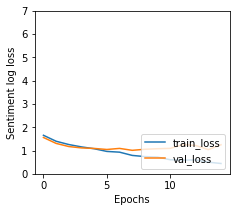

In [27]:
learning_rate = 0.001
weight_decay = 0.0#0001

optimizer = torch.optim.Adam([W,U,V], lr=learning_rate, weight_decay=weight_decay)

history = []
epochs = 15
for epoch in range(1, epochs + 1):
#     print(f"EPOCH {epoch}")
    epoch_training_loss = 0.0
    epoch_training_accur = 0.0
    for i in range(0, n): # an epoch trains all input records
        x = X_train[i]
        o = forward([x])
#         o = forward1(x)
        if i<0:
            print(o)
        '''
#         print(i,x)
        h = torch.zeros(nhidden, 1, dtype=torch.float64, device=device, requires_grad=False)  # reset hidden state at start of record
        for j in range(len(x)):  # for each char in a name
            x_onehot = onehot(x[j])
            h = W.mm(h) + U.mm(x_onehot)# + b
#             h = torch.tanh(h)  # squish to (-1,+1)
            h = torch.relu(h)
#             print("h",h)
        # h is output of RNN, a fancy CBOW embedding for variable-length sequence in x
        # run through a final layer to map that h to a one-hot encoded predicted class
#         h = dropout(h, p=0.4)
        o = V.mm(h)# + Vb
        o = o.reshape(1,nclasses)
        o = softmax(o)
#             print("softmax",o,"y_train[i]",y_train[i])
        '''
        loss = cross_entropy(o, y_train[i])
        loss.backward() # autograd computes U.grad, M.grad, ...
        optimizer.step()
        optimizer.zero_grad()

        epoch_training_loss += loss.detach().item()
        correct = torch.argmax(o[0])==y_train[i]
        epoch_training_accur += correct
#         print("\tword loss", torch.mean(torch.tensor(losses)).item())

    epoch_training_loss /= n
    epoch_training_accur /= n
#     print(f"Epoch {epoch:3d} training loss {epoch_training_loss:7.4f} accur {epoch_training_accur:7.4f}")

    with torch.no_grad():
        o = forward(X_train)#, apply_softmax=False)
        train_loss = cross_entropy(o, y_train)
#         train_loss = F.cross_entropy(o, torch.tensor(y_train,dtype=torch.long))
        correct = torch.argmax(o, dim=1).cpu()==torch.tensor(y_train)
        train_accur = torch.sum(correct) / float(len(X_train))
        o = forward(X_valid)#, apply_softmax=False)
        valid_loss = cross_entropy(o, y_valid)
#         valid_loss = F.cross_entropy(o, torch.tensor(y_valid,dtype=torch.long))
        correct = torch.argmax(o, dim=1).cpu()==torch.tensor(y_valid)
        valid_accur = torch.sum(correct) / float(len(X_valid))
        history.append((train_loss, valid_loss))
        print(f"Epoch: {epoch:3d} accum loss {epoch_training_loss:7.4f} accur {epoch_training_accur:4.3f} | train loss {train_loss:7.4f} accur {train_accur:4.3f} | valid loss {valid_loss:7.4f} accur {valid_accur:4.3f}")

history = torch.tensor(history)
plot_history(history, yrange=(0,7))

## Train using mini-batch SGD, multiple records used to compute gradient

Still w/o vectorization, one record at a time. Just do a batch before computing gradients.

In [28]:
nhidden = 80
nfeatures = len(vocab)
nclasses = len(y_cats)
n = len(X_train)
print(f"{n:,d} training records, {nfeatures} features (chars), {nclasses} target languages, state is {nhidden}-vector")

1,600 training records, 28 features (chars), 18 target languages, state is 80-vector


In [29]:
W = torch.eye(nhidden, nhidden, dtype=torch.float64, device=device, requires_grad=True)
U = randn(nhidden, nfeatures, device=device, requires_grad=True) # embed one-hot char vec
V = randn(nclasses, nhidden, device=device, requires_grad=True)  # take RNN output (h) and predict target
# b = randn(nhidden, 1, device=device, requires_grad=True)  # bias
# Vb = randn(nclasses, 1, device=device, requires_grad=True)  # bias for final, classifier layer

In [ ]:
learning_rate = 0.001
weight_decay = 0.0#0001
batch_size = 32

optimizer = torch.optim.Adam([W,U,V], lr=learning_rate, weight_decay=weight_decay)

history = []
epochs = 10
for epoch in range(1, epochs + 1):
#     print(f"EPOCH {epoch}")
    epoch_training_loss = 0.0
    epoch_training_accur = 0.0
    for p in range(0, n, batch_size):  # do one epoch
        loss = 0
        for i in range(p, p+batch_size): # do one batch
            x = X_train[i]
    #         print(i,x)
            h = torch.zeros(nhidden, 1, dtype=torch.float64, requires_grad=False)  # reset hidden state at start of record
            h = h.to(device)
            for j in range(len(x)):  # for each char in a name
                x_onehot = onehot(x[j])
                h = W.mm(h) + U.mm(x_onehot)# + b
#                 h = torch.tanh(h)  # squish to (-1,+1)
                h = torch.relu(h)
    #             print("h",h)
            # h is output of RNN, a fancy CBOW embedding for variable-length sequence in x
            # run through a final layer to map that h to a one-hot encoded predicted class
    #         h = dropout(h, p=0.4)
            o = V.mm(h)# + Vb
            o = o.reshape(1,nclasses)
    #             print("o",o)
            o = softmax(o)
    #             print("softmax",o,"y_train[i]",y_train[i])
            word_loss = cross_entropy(o, y_train[i])
            loss = loss + word_loss
            epoch_training_loss += loss.item()
            correct = torch.argmax(o)==y_train[i]
            epoch_training_accur += correct
    #         print("\tword loss", torch.mean(torch.tensor(losses)).item())

        loss /= batch_size
        
        loss.backward() # autograd computes U.grad, M.grad, ...
        optimizer.step()
        optimizer.zero_grad()

    epoch_training_loss /= n
    epoch_training_accur /= n
#     print(f"Epoch {epoch:3d} training loss {epoch_training_loss:7.4f} accur {epoch_training_accur:7.4f}")
    
    with torch.no_grad():
        o = forward(X_train)
        train_loss = cross_entropy(o, y_train)
        correct = torch.argmax(o, dim=1).cpu()==torch.tensor(y_train)
        train_accur = torch.sum(correct) / float(len(X_train))
        o = forward(X_valid)
        valid_loss = cross_entropy(o, y_valid)
        correct = torch.argmax(o, dim=1).cpu()==torch.tensor(y_valid)
        valid_accur = torch.sum(correct) / float(len(X_valid))
        history.append((train_loss, valid_loss))
        print(f"Epoch: {epoch:3d} accum loss {epoch_training_loss:7.4f} accur {epoch_training_accur:4.3f} | train loss {train_loss:7.4f} accur {train_accur:4.3f} | valid loss {valid_loss:7.4f} accur {valid_accur:4.3f}")

history = torch.tensor(history)
plot_history(history, yrange=(0,7))

Epoch:   1 accum loss 38.5266 accur 0.446 | train loss  2.0100 accur 0.456 | valid loss  2.0556 accur 0.510
Epoch:   2 accum loss 31.2749 accur 0.456 | train loss  1.8531 accur 0.456 | valid loss  1.8631 accur 0.510
Epoch:   3 accum loss 29.7957 accur 0.456 | train loss  1.7489 accur 0.456 | valid loss  1.7067 accur 0.512
